Подключение библиотек

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, welch, periodogram
from scipy.fft import fft, fftfreq


Моделирование таламокортикальной системы

In [8]:
# Параметры модели
params = {
    "tau": [1.0, 1.0, 1.0],  # Временные константы τ₁, τ₂, τ₃
    "k": [1.0, 1.0, 1.0],  # Коэффициенты усиления k₁, k₂, k₃
    "T": [0.0, 0.5, 0.5],  # Пороги T₁, T₂, T₃
    "k_ex": 1.0,  # Коэффициент входного сигнала kₑₓ
    "k_ij": {  # Коэффициенты связей
        "13": 1.0,  # k₁₃ (ретикулярное ядро → таламус)
        "21": 1.0,  # k₂₁ (таламус → кора)
        "22": 0.0,  # k₂₂ (кора → кора)
        "32": 1.0,  # k₃₂ (кора → ретикулярное ядро)
    },
}

# Функция энергообеспечения F(x)
def F(x):
    return 0.5 + 0.5 * np.tanh(20 * x)

# Моделирование системы
def simulate_system(t_range, u_ex, initial_conditions, params):
    dt = t_range[1] - t_range[0]  # Шаг времени
    U1, U2, U3 = np.zeros_like(t_range), np.zeros_like(t_range), np.zeros_like(t_range)
    U1[0], U2[0], U3[0] = initial_conditions

    for k in range(len(t_range) - 1):

        arg1 = -params["T"][0] + params["k_ex"] * u_ex[k] - params["k_ij"]["13"] * U3[k]
        arg2 = (
            -params["T"][1]
            + params["k_ij"]["21"] * U1[k]
            + params["k_ij"]["22"] * U2[k]
        )
        arg3 = -params["T"][2] + params["k_ij"]["32"] * U2[k]

        # Производные (dU/dt)
        dU1 = (-U1[k] + params["k"][0] * F(arg1)) / params["tau"][0]
        dU2 = (-U2[k] + params["k"][1] * F(arg2)) / params["tau"][1]
        dU3 = (-U3[k] + params["k"][2] * F(arg3)) / params["tau"][2]

        # Интегрирование (Эйлер)
        U1[k + 1] = U1[k] + dt * dU1
        U2[k + 1] = U2[k] + dt * dU2
        U3[k + 1] = U3[k] + dt * dU3

    return U1, U2, U3

Моделирование сигнала

In [9]:
signal_params = {
    "fmin": 0,
    "fmax": 15,
    "duration": 20,
    "signal_ave": 0.5,
    "signal_amplitude": 0.5,
    "t_start": 10,
}
range_t = np.arange(0, 40, 0.001)
uex = np.zeros_like(range_t)
fex = np.zeros_like(range_t)

for i in range(range_t.size):
    t = range_t[i]  # текущее время
    t_start = signal_params["t_start"]
    duration = signal_params["duration"]

    if t_start <= t <= t_start + duration:
        # Относительное время от начала сигнала
        t_rel = t - t_start

        phase = 2 * np.pi * (
            signal_params["fmin"] * t_rel +
            0.5 * (signal_params["fmax"] - signal_params["fmin"]) * t_rel**2 / duration
        )

        # Формирование сигнала
        uex[i] = signal_params["signal_amplitude"] * np.sin(phase) + signal_params["signal_ave"]

        frequency = signal_params["fmin"] + (signal_params["fmax"] - signal_params["fmin"]) * t_rel / duration
        fex[i] = frequency

    else:
        uex[i] = signal_params["signal_ave"]
        fex[i] = 0

Запуск симуляции

In [10]:
initial_conditions = (0, 0, 0)
u1, u2, u3 = simulate_system(range_t, uex, initial_conditions, params)

Спектральный анализ

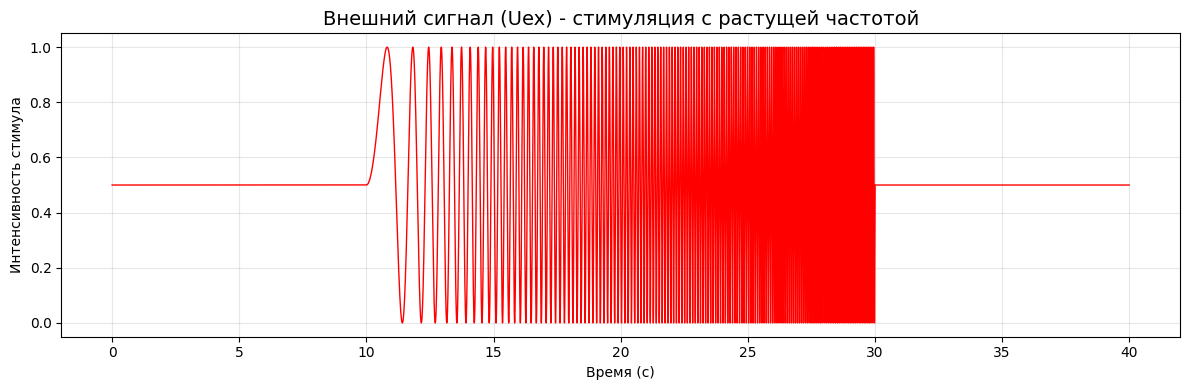

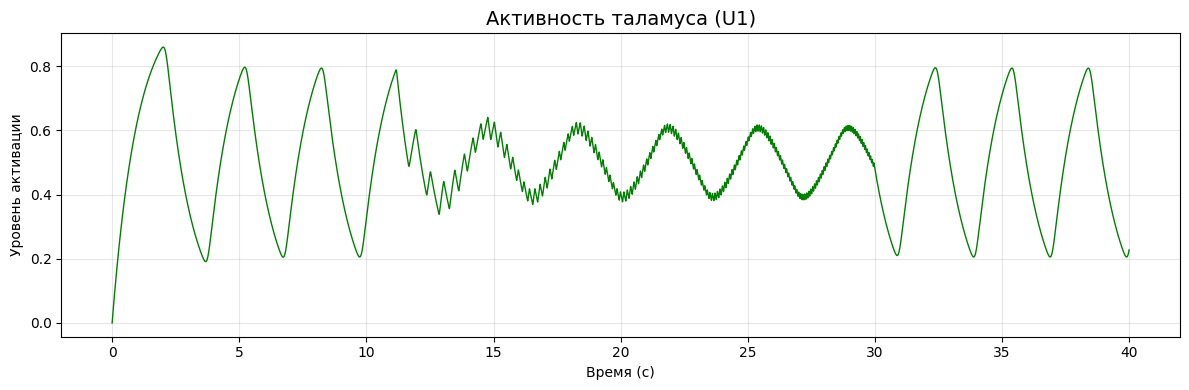

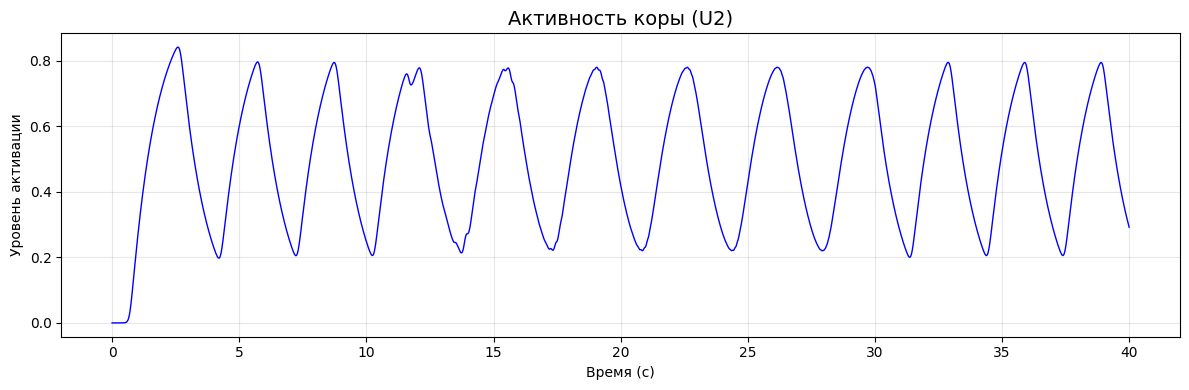

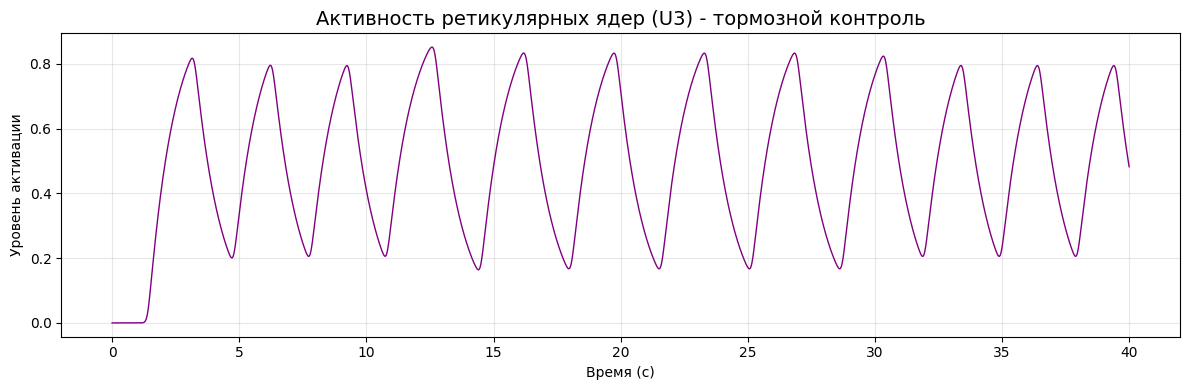

Спектрограмма входного сигнала:


/tmp/ipython-input-2126268943.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')


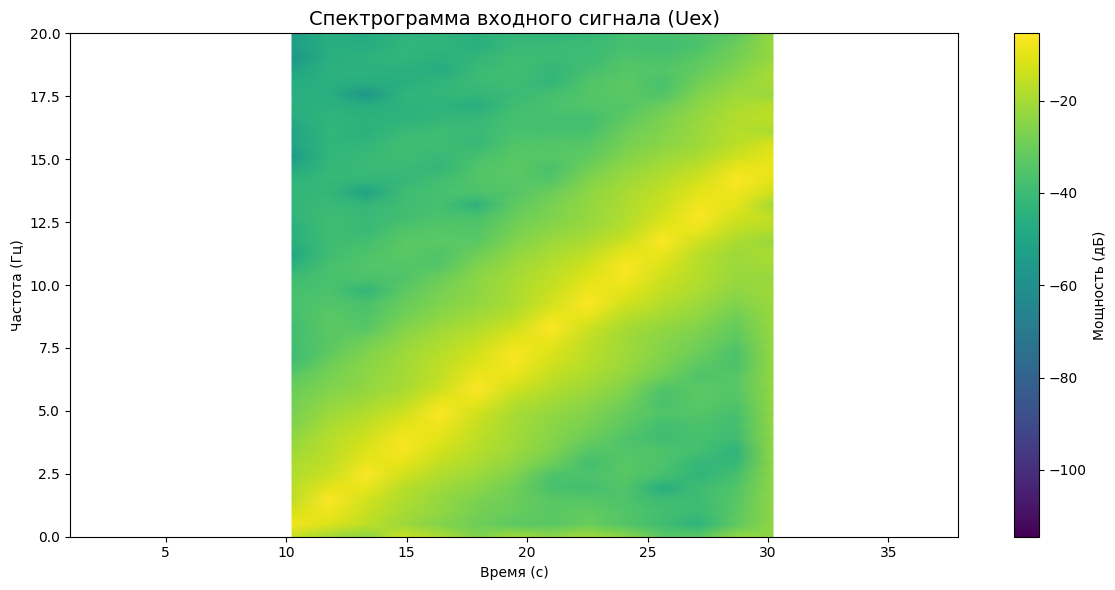

Спектрограмма таламического сигнала (U1 - аналог ЭЭГ)):


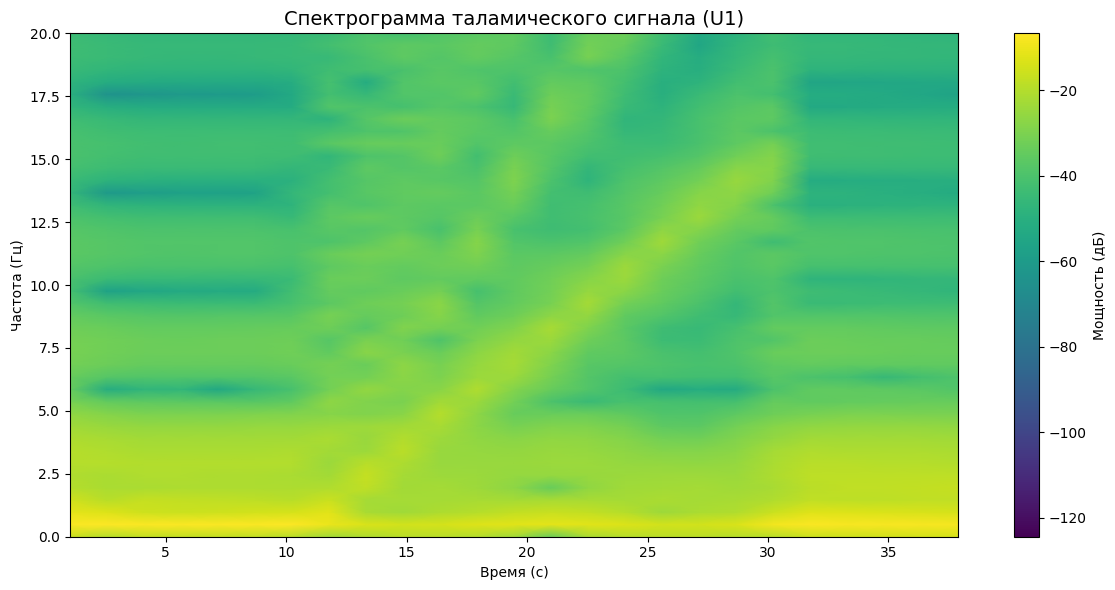

In [12]:
def plot_signal(signal, range_t, title="Сигнал", ylabel="Амплитуда", color='blue'):

    plt.figure(figsize=(12, 4))
    plt.plot(range_t, signal, color=color, linewidth=1)
    plt.xlabel('Время (с)')
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Спектрограмма для анализа динамики частот во времени
def plot_spectrogram(signal, t_range, fs=1000, title="Спектрограмма"):

    plt.figure(figsize=(12, 6))
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=2048, noverlap=512, scaling='density', mode='magnitude')

    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    plt.colorbar(label='Мощность (дБ)')
    plt.ylabel('Частота (Гц)')
    plt.xlabel('Время (с)')
    plt.title(title, fontsize=14)
    plt.ylim(0, 20)  # Ограничиваем диапазон для наглядности
    plt.tight_layout()
    plt.show()


plot_signal(uex, range_t, title="Внешний сигнал (Uex) - стимуляция с растущей частотой",
           ylabel="Интенсивность стимула", color='red')

plot_signal(u1, range_t, title="Активность таламуса (U1)",
           ylabel="Уровень активации", color='green')

plot_signal(u2, range_t, title="Активность коры (U2)",
           ylabel="Уровень активации", color='blue')

plot_signal(u3, range_t, title="Активность ретикулярных ядер (U3) - тормозной контроль",
           ylabel="Уровень активации", color='purple')

# Анализируем кортикальный сигнал (U2) как аналог ЭЭГ

print("Спектрограмма входного сигнала:")
plot_spectrogram(uex, range_t, title="Спектрограмма входного сигнала (Uex)")

print("Спектрограмма таламического сигнала (U1 - аналог ЭЭГ)):")
plot_spectrogram(u1, range_t, title="Спектрограмма таламического сигнала (U1)")



In [6]:
# Запустим систему без внешнего сигнала (только постоянная составляющая)
uex_constant = np.ones_like(range_t) * 0.5  # Постоянное фоновое воздействие на таламус
u1_free, u2_free, u3_free = simulate_system(range_t, uex_constant, initial_conditions, params)

# Анализ установившегося режима (после 5 секунд)
steady_state = u2_free[range_t > 5]

# Спектральный анализ собственных колебаний
f, Pxx = periodogram(steady_state, fs=1000)
dominant_freq = f[np.argmax(Pxx)]
print(f"Собственная частота системы: {dominant_freq:.2f} Гц")
print(f"Мощность на этой частоте: {np.max(Pxx):.2e}")

Собственная частота системы: 0.34 Гц
Мощность на этой частоте: 8.17e-01
